- https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [109]:
import os
import random
import numpy as np
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## DataLoader

### opt
- resize_or_crop = resize_and_crop
- loadSize = 286


In [87]:
# hyperparameters
load_size = 286
fine_size = 256
batch_size = 16

In [104]:
class UnalignedDataset(data.Dataset):

    def __init__(self, is_train):
        super(data.Dataset, self).__init__()

        root_dir = os.path.join('data', 'horse2zebra')
        train_dir_A = os.path.join(root_dir, 'trainA')
        train_dir_B = os.path.join(root_dir, 'trainB')

        self.image_paths_A = self._make_dataset(train_dir_A)
        self.image_paths_B = self._make_dataset(train_dir_B)

        self.size_A = len(self.image_paths_A)
        self.size_B = len(self.image_paths_B)

        self.transform = self._make_transform(is_train)

    def __getitem__(self, index):
        index_A = index % self.size_A
        path_A = self.image_paths_A[index_A]
        
        # クラスBの画像はランダムに選択
        index_B = random.randint(0, self.size_B - 1)
        path_B = self.image_paths_B[index_B]

#         print('(A, B) = (%d, %d)' % (index_A, index_B))
        
        img_A = Image.open(path_A).convert('RGB')
        img_B = Image.open(path_B).convert('RGB')
        
        A = self.transform(img_A)
        B = self.transform(img_B)
        
        return {'A': A, 'B': B, 'path_A': path_A, 'path_B': path_B}
    
    def __len__(self):
        return max(self.size_A, self.size_B)

    def _make_dataset(self, dir):
        images = []
        for fname in os.listdir(dir):
            if fname.endswith('.jpg'):
                path = os.path.join(dir, fname)
                images.append(path)
        sorted(images)
        return images

    def _make_transform(self, is_train):
        transforms_list = []
        transforms_list.append(transforms.Resize((load_size, load_size), Image.BICUBIC))
        transforms_list.append(transforms.RandomCrop(fine_size))
        if is_train:
            transforms_list.append(transforms.RandomHorizontalFlip())
        transforms_list.append(transforms.ToTensor())
        transforms_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))  # [0, 1] => [-1, 1]
        return transforms.Compose(transforms_list)
            

In [105]:
dataset = UnalignedDataset(is_train=True)
train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=0)

In [106]:
batch = iter(train_loader).next()

In [107]:
print(batch['A'].shape)
print(batch['B'].shape)
print(batch['path_A'])
print(batch['path_B'])

torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
['data/horse2zebra/trainA/n02381460_1425.jpg', 'data/horse2zebra/trainA/n02381460_908.jpg', 'data/horse2zebra/trainA/n02381460_2198.jpg', 'data/horse2zebra/trainA/n02381460_7512.jpg', 'data/horse2zebra/trainA/n02381460_8903.jpg', 'data/horse2zebra/trainA/n02381460_2223.jpg', 'data/horse2zebra/trainA/n02381460_6294.jpg', 'data/horse2zebra/trainA/n02381460_1388.jpg', 'data/horse2zebra/trainA/n02381460_4536.jpg', 'data/horse2zebra/trainA/n02381460_6876.jpg', 'data/horse2zebra/trainA/n02381460_4112.jpg', 'data/horse2zebra/trainA/n02381460_1645.jpg', 'data/horse2zebra/trainA/n02381460_8895.jpg', 'data/horse2zebra/trainA/n02381460_3229.jpg', 'data/horse2zebra/trainA/n02381460_921.jpg', 'data/horse2zebra/trainA/n02381460_2793.jpg']
['data/horse2zebra/trainB/n02391049_514.jpg', 'data/horse2zebra/trainB/n02391049_745.jpg', 'data/horse2zebra/trainB/n02391049_2701.jpg', 'data/horse2zebra/trainB/n02391049_328.jpg', 'data/horse2zebra/train

(-0.5, 1033.5, 1033.5, -0.5)

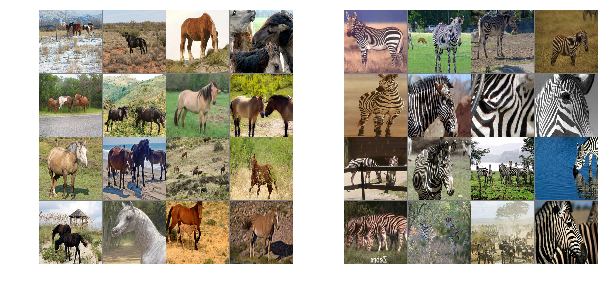

In [116]:
# データの描画
def imshow(img):
    npimg = img.numpy()
    npimg = 0.5 * (npimg + 1)  # [-1,1] => [0, 1]
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

batch = iter(train_loader).next()
images_A = batch['A']  # horses
images_B = batch['B']  # zebras

plt.figure(figsize=(10, 20))

plt.subplot(1, 2, 1)
imshow(make_grid(images_A, nrow=4))
plt.axis('off')

plt.subplot(1, 2, 2)
imshow(make_grid(images_B, nrow=4))
plt.axis('off')